In [1]:
# -*- coding: utf-8 -*-

import pickle as pkl
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import pandas as pd
import numpy as np
import math
import os
import numpy.linalg as la
from acell import preprocess_data,load_assist_data
from tgcn import tgcnCell
from gru import GRUCell 

from visualization import plot_result,plot_error
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import time

time_start = time.time()

###### Settings ######
flags = tf.app.flags
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('training_epoch', 2500, 'Number of epochs to train.')
flags.DEFINE_integer('gru_units', 100, 'hidden units of gru.')
flags.DEFINE_integer('seq_len', 5, 'time length of inputs.')
flags.DEFINE_integer('pre_len', 1, 'time length of prediction.')
flags.DEFINE_float('train_rate', 0.8, 'rate of training set.')
flags.DEFINE_integer('batch_size', 64, 'batch size.')
flags.DEFINE_string('dataset', '3611817550', 'dataset')
flags.DEFINE_string('model_name', 'tgcn', 'ast-gcn/tgcn/gru')
flags.DEFINE_integer('scheme', 14, 'scheme')
                            #记得改dim
flags.DEFINE_string('noise_name', 'None', 'None or Gauss or Possion')
flags.DEFINE_integer('noise_param', 0, 'Parameter for noise')
#flags.DEFINE_integer('dim', 20, 'DIM')

model_name = FLAGS.model_name
noise_name = FLAGS.noise_name
data_name = FLAGS.dataset
train_rate =  FLAGS.train_rate
seq_len = FLAGS.seq_len
output_dim = pre_len = FLAGS.pre_len
batch_size = FLAGS.batch_size
lr = FLAGS.learning_rate
training_epoch = FLAGS.training_epoch
gru_units = FLAGS.gru_units
#dim = FLAGS.dim
scheme = FLAGS.scheme
PG = FLAGS.noise_param

11
model: tgcn
scheme: tgcn
noise_name: None
noise_param: 0
11
(16814, 5, 30)
(16814, 1, 30)
(4200, 5, 30)
(4200, 1, 30)
y_pred_shape: (?, 30)
label_shape: (?, 30)
Iter:0 train_rmse:0.1327 test_loss:1.092e+03 test_rmse:6.262 test_acc:0.7623
Iter:1 train_rmse:0.1143 test_loss:770.7 test_rmse:6.625 test_acc:0.8003
Iter:2 train_rmse:0.1084 test_loss:706.2 test_rmse:5.844 test_acc:0.8089
Iter:3 train_rmse:0.1023 test_loss:637.5 test_rmse:5.496 test_acc:0.8184
Iter:4 train_rmse:0.09514 test_loss:537.8 test_rmse:5.254 test_acc:0.8333
Iter:5 train_rmse:0.0902 test_loss:473.7 test_rmse:4.877 test_acc:0.8435
Iter:6 train_rmse:0.084 test_loss:476.0 test_rmse:4.458 test_acc:0.8432
Iter:7 train_rmse:0.07957 test_loss:361.9 test_rmse:3.878 test_acc:0.8633
Iter:8 train_rmse:0.07331 test_loss:348.5 test_rmse:3.927 test_acc:0.8658
Iter:9 train_rmse:0.07854 test_loss:293.7 test_rmse:3.307 test_acc:0.8769
Iter:10 train_rmse:0.07525 test_loss:312.6 test_rmse:3.205 test_acc:0.8731
Iter:11 train_rmse:0.065

Iter:108 train_rmse:0.04547 test_loss:103.0 test_rmse:2.027 test_acc:0.9272
Iter:109 train_rmse:0.04569 test_loss:110.5 test_rmse:2.183 test_acc:0.9245
Iter:110 train_rmse:0.04536 test_loss:102.7 test_rmse:2.015 test_acc:0.9273
Iter:111 train_rmse:0.04509 test_loss:104.8 test_rmse:2.056 test_acc:0.9265
Iter:112 train_rmse:0.0454 test_loss:107.0 test_rmse:2.1 test_acc:0.9258
Iter:113 train_rmse:0.04537 test_loss:105.4 test_rmse:2.064 test_acc:0.9263
Iter:114 train_rmse:0.04538 test_loss:99.52 test_rmse:1.943 test_acc:0.9284
Iter:115 train_rmse:0.04484 test_loss:101.9 test_rmse:1.994 test_acc:0.9276
Iter:116 train_rmse:0.04545 test_loss:109.6 test_rmse:2.134 test_acc:0.9248
Iter:117 train_rmse:0.04539 test_loss:105.2 test_rmse:2.055 test_acc:0.9264
Iter:118 train_rmse:0.04518 test_loss:98.51 test_rmse:1.902 test_acc:0.9288
Iter:119 train_rmse:0.04414 test_loss:96.51 test_rmse:1.857 test_acc:0.9295
Iter:120 train_rmse:0.04493 test_loss:97.86 test_rmse:1.878 test_acc:0.929
Iter:121 train_r

Iter:217 train_rmse:0.04148 test_loss:82.03 test_rmse:1.203 test_acc:0.935
Iter:218 train_rmse:0.04225 test_loss:91.13 test_rmse:1.247 test_acc:0.9315
Iter:219 train_rmse:0.0414 test_loss:82.6 test_rmse:1.19 test_acc:0.9348
Iter:220 train_rmse:0.04143 test_loss:86.67 test_rmse:1.2 test_acc:0.9332
Iter:221 train_rmse:0.04144 test_loss:82.5 test_rmse:1.181 test_acc:0.9348
Iter:222 train_rmse:0.0414 test_loss:85.93 test_rmse:1.194 test_acc:0.9335
Iter:223 train_rmse:0.04195 test_loss:81.17 test_rmse:1.203 test_acc:0.9354
Iter:224 train_rmse:0.04126 test_loss:83.6 test_rmse:1.179 test_acc:0.9344
Iter:225 train_rmse:0.04176 test_loss:80.5 test_rmse:1.21 test_acc:0.9356
Iter:226 train_rmse:0.04162 test_loss:87.71 test_rmse:1.213 test_acc:0.9328
Iter:227 train_rmse:0.04275 test_loss:83.42 test_rmse:1.372 test_acc:0.9345
Iter:228 train_rmse:0.04145 test_loss:80.84 test_rmse:1.171 test_acc:0.9355
Iter:229 train_rmse:0.04124 test_loss:81.61 test_rmse:1.166 test_acc:0.9352
Iter:230 train_rmse:0.0

Iter:326 train_rmse:0.03945 test_loss:71.95 test_rmse:1.105 test_acc:0.9391
Iter:327 train_rmse:0.04012 test_loss:76.14 test_rmse:1.169 test_acc:0.9374
Iter:328 train_rmse:0.0402 test_loss:72.61 test_rmse:1.127 test_acc:0.9389
Iter:329 train_rmse:0.03956 test_loss:71.16 test_rmse:1.089 test_acc:0.9395
Iter:330 train_rmse:0.03957 test_loss:71.87 test_rmse:1.106 test_acc:0.9392
Iter:331 train_rmse:0.03933 test_loss:71.99 test_rmse:1.094 test_acc:0.9391
Iter:332 train_rmse:0.03987 test_loss:72.96 test_rmse:1.141 test_acc:0.9387
Iter:333 train_rmse:0.03937 test_loss:71.05 test_rmse:1.088 test_acc:0.9395
Iter:334 train_rmse:0.04071 test_loss:82.56 test_rmse:1.274 test_acc:0.9348
Iter:335 train_rmse:0.03939 test_loss:71.36 test_rmse:1.087 test_acc:0.9394
Iter:336 train_rmse:0.03952 test_loss:73.09 test_rmse:1.11 test_acc:0.9387
Iter:337 train_rmse:0.03946 test_loss:71.68 test_rmse:1.094 test_acc:0.9392
Iter:338 train_rmse:0.04132 test_loss:71.96 test_rmse:1.098 test_acc:0.9391
Iter:339 train

Iter:435 train_rmse:0.03844 test_loss:69.17 test_rmse:1.034 test_acc:0.9403
Iter:436 train_rmse:0.03819 test_loss:69.74 test_rmse:1.047 test_acc:0.9401
Iter:437 train_rmse:0.03829 test_loss:69.49 test_rmse:1.037 test_acc:0.9402
Iter:438 train_rmse:0.03827 test_loss:69.98 test_rmse:1.056 test_acc:0.94
Iter:439 train_rmse:0.0383 test_loss:69.66 test_rmse:1.042 test_acc:0.9401
Iter:440 train_rmse:0.03894 test_loss:70.58 test_rmse:1.028 test_acc:0.9397
Iter:441 train_rmse:0.03822 test_loss:69.05 test_rmse:1.03 test_acc:0.9404
Iter:442 train_rmse:0.03829 test_loss:69.38 test_rmse:1.044 test_acc:0.9402
Iter:443 train_rmse:0.03816 test_loss:69.62 test_rmse:1.05 test_acc:0.9401
Iter:444 train_rmse:0.03833 test_loss:68.49 test_rmse:1.01 test_acc:0.9406
Iter:445 train_rmse:0.03815 test_loss:69.75 test_rmse:1.053 test_acc:0.94
Iter:446 train_rmse:0.03832 test_loss:71.87 test_rmse:1.111 test_acc:0.9391
Iter:447 train_rmse:0.03866 test_loss:68.92 test_rmse:1.014 test_acc:0.9404
Iter:448 train_rmse:

Iter:544 train_rmse:0.03778 test_loss:67.13 test_rmse:0.9933 test_acc:0.9412
Iter:545 train_rmse:0.03773 test_loss:67.47 test_rmse:1.014 test_acc:0.941
Iter:546 train_rmse:0.03764 test_loss:67.0 test_rmse:0.9842 test_acc:0.9412
Iter:547 train_rmse:0.03766 test_loss:67.51 test_rmse:1.019 test_acc:0.941
Iter:548 train_rmse:0.03776 test_loss:67.01 test_rmse:0.9944 test_acc:0.9412
Iter:549 train_rmse:0.03771 test_loss:66.96 test_rmse:0.9882 test_acc:0.9413
Iter:550 train_rmse:0.03788 test_loss:68.99 test_rmse:1.063 test_acc:0.9404
Iter:551 train_rmse:0.03774 test_loss:69.29 test_rmse:1.07 test_acc:0.9402
Iter:552 train_rmse:0.03768 test_loss:67.31 test_rmse:1.005 test_acc:0.9411
Iter:553 train_rmse:0.03798 test_loss:67.41 test_rmse:0.971 test_acc:0.9411
Iter:554 train_rmse:0.03795 test_loss:68.62 test_rmse:1.053 test_acc:0.9405
Iter:555 train_rmse:0.03772 test_loss:68.32 test_rmse:1.043 test_acc:0.9407
Iter:556 train_rmse:0.03761 test_loss:68.56 test_rmse:1.049 test_acc:0.9406
Iter:557 tra

Iter:652 train_rmse:0.03756 test_loss:66.59 test_rmse:0.9919 test_acc:0.9414
Iter:653 train_rmse:0.03763 test_loss:65.58 test_rmse:0.9382 test_acc:0.9419
Iter:654 train_rmse:0.03753 test_loss:67.5 test_rmse:1.022 test_acc:0.941
Iter:655 train_rmse:0.03782 test_loss:67.47 test_rmse:1.021 test_acc:0.941
Iter:656 train_rmse:0.03739 test_loss:65.64 test_rmse:0.9458 test_acc:0.9418
Iter:657 train_rmse:0.03759 test_loss:67.04 test_rmse:1.008 test_acc:0.9412
Iter:658 train_rmse:0.03807 test_loss:71.18 test_rmse:1.121 test_acc:0.9394
Iter:659 train_rmse:0.03763 test_loss:68.88 test_rmse:1.059 test_acc:0.9404
Iter:660 train_rmse:0.03743 test_loss:65.82 test_rmse:0.9745 test_acc:0.9417
Iter:661 train_rmse:0.03735 test_loss:65.91 test_rmse:0.9605 test_acc:0.9417
Iter:662 train_rmse:0.03753 test_loss:65.26 test_rmse:0.943 test_acc:0.942
Iter:663 train_rmse:0.03764 test_loss:69.31 test_rmse:1.075 test_acc:0.9402
Iter:664 train_rmse:0.03747 test_loss:67.46 test_rmse:1.024 test_acc:0.941
Iter:665 tra

Iter:760 train_rmse:0.03741 test_loss:65.25 test_rmse:0.9166 test_acc:0.942
Iter:761 train_rmse:0.03739 test_loss:64.48 test_rmse:0.918 test_acc:0.9423
Iter:762 train_rmse:0.03716 test_loss:65.44 test_rmse:0.9642 test_acc:0.9419
Iter:763 train_rmse:0.03714 test_loss:65.13 test_rmse:0.9455 test_acc:0.942
Iter:764 train_rmse:0.03755 test_loss:66.85 test_rmse:0.9346 test_acc:0.9413
Iter:765 train_rmse:0.03777 test_loss:69.56 test_rmse:1.084 test_acc:0.9401
Iter:766 train_rmse:0.03719 test_loss:65.25 test_rmse:0.9621 test_acc:0.942
Iter:767 train_rmse:0.03767 test_loss:67.84 test_rmse:1.043 test_acc:0.9409
Iter:768 train_rmse:0.03718 test_loss:65.27 test_rmse:0.9383 test_acc:0.942
Iter:769 train_rmse:0.03725 test_loss:64.77 test_rmse:0.9389 test_acc:0.9422
Iter:770 train_rmse:0.03752 test_loss:68.14 test_rmse:1.047 test_acc:0.9407
Iter:771 train_rmse:0.03723 test_loss:65.52 test_rmse:0.9672 test_acc:0.9419
Iter:772 train_rmse:0.03765 test_loss:67.11 test_rmse:1.019 test_acc:0.9412
Iter:773

Iter:868 train_rmse:0.03757 test_loss:67.36 test_rmse:1.029 test_acc:0.9411
Iter:869 train_rmse:0.03773 test_loss:67.82 test_rmse:1.041 test_acc:0.9409
Iter:870 train_rmse:0.03725 test_loss:66.5 test_rmse:1.004 test_acc:0.9414
Iter:871 train_rmse:0.03753 test_loss:66.77 test_rmse:1.013 test_acc:0.9413
Iter:872 train_rmse:0.03801 test_loss:68.74 test_rmse:1.068 test_acc:0.9405
Iter:873 train_rmse:0.03738 test_loss:66.28 test_rmse:1.003 test_acc:0.9415
Iter:874 train_rmse:0.03694 test_loss:64.48 test_rmse:0.9269 test_acc:0.9423
Iter:875 train_rmse:0.03707 test_loss:65.73 test_rmse:0.9881 test_acc:0.9418
Iter:876 train_rmse:0.03703 test_loss:64.81 test_rmse:0.9504 test_acc:0.9422
Iter:877 train_rmse:0.03702 test_loss:64.0 test_rmse:0.9096 test_acc:0.9426
Iter:878 train_rmse:0.03709 test_loss:65.48 test_rmse:0.9743 test_acc:0.9419
Iter:879 train_rmse:0.03706 test_loss:66.64 test_rmse:1.009 test_acc:0.9414
Iter:880 train_rmse:0.03723 test_loss:66.38 test_rmse:1.003 test_acc:0.9415
Iter:881 

Iter:976 train_rmse:0.03743 test_loss:67.15 test_rmse:1.03 test_acc:0.9412
Iter:977 train_rmse:0.0376 test_loss:67.52 test_rmse:1.036 test_acc:0.941
Iter:978 train_rmse:0.03731 test_loss:67.75 test_rmse:1.044 test_acc:0.9409
Iter:979 train_rmse:0.03757 test_loss:69.55 test_rmse:1.096 test_acc:0.9401
Iter:980 train_rmse:0.03725 test_loss:65.98 test_rmse:0.996 test_acc:0.9417
Iter:981 train_rmse:0.0368 test_loss:65.76 test_rmse:0.9868 test_acc:0.9418
Iter:982 train_rmse:0.03703 test_loss:66.11 test_rmse:1.001 test_acc:0.9416
Iter:983 train_rmse:0.03689 test_loss:65.16 test_rmse:0.9686 test_acc:0.942
Iter:984 train_rmse:0.03683 test_loss:63.51 test_rmse:0.8972 test_acc:0.9428
Iter:985 train_rmse:0.03767 test_loss:69.08 test_rmse:1.071 test_acc:0.9403
Iter:986 train_rmse:0.03707 test_loss:66.28 test_rmse:1.002 test_acc:0.9415
Iter:987 train_rmse:0.03676 test_loss:64.54 test_rmse:0.9467 test_acc:0.9423
Iter:988 train_rmse:0.03751 test_loss:68.51 test_rmse:1.057 test_acc:0.9406
Iter:989 trai

Iter:1083 train_rmse:0.03696 test_loss:64.18 test_rmse:0.9427 test_acc:0.9425
Iter:1084 train_rmse:0.03669 test_loss:63.65 test_rmse:0.9197 test_acc:0.9427
Iter:1085 train_rmse:0.03689 test_loss:64.41 test_rmse:0.9436 test_acc:0.9424
Iter:1086 train_rmse:0.03671 test_loss:63.34 test_rmse:0.9073 test_acc:0.9429
Iter:1087 train_rmse:0.03662 test_loss:63.21 test_rmse:0.9055 test_acc:0.9429
Iter:1088 train_rmse:0.03677 test_loss:66.02 test_rmse:0.996 test_acc:0.9416
Iter:1089 train_rmse:0.03698 test_loss:61.16 test_rmse:0.8374 test_acc:0.9438
Iter:1090 train_rmse:0.03698 test_loss:62.26 test_rmse:0.8728 test_acc:0.9433
Iter:1091 train_rmse:0.03669 test_loss:62.98 test_rmse:0.8982 test_acc:0.943
Iter:1092 train_rmse:0.03662 test_loss:63.01 test_rmse:0.8939 test_acc:0.943
Iter:1093 train_rmse:0.0372 test_loss:65.36 test_rmse:0.9718 test_acc:0.9419
Iter:1094 train_rmse:0.03674 test_loss:63.7 test_rmse:0.9199 test_acc:0.9427
Iter:1095 train_rmse:0.03703 test_loss:66.27 test_rmse:1.002 test_acc

Iter:1189 train_rmse:0.03654 test_loss:62.6 test_rmse:0.881 test_acc:0.9432
Iter:1190 train_rmse:0.0368 test_loss:65.01 test_rmse:0.9521 test_acc:0.9421
Iter:1191 train_rmse:0.03695 test_loss:64.7 test_rmse:0.9453 test_acc:0.9422
Iter:1192 train_rmse:0.03697 test_loss:64.89 test_rmse:0.9484 test_acc:0.9421
Iter:1193 train_rmse:0.0375 test_loss:67.9 test_rmse:0.9348 test_acc:0.9408
Iter:1194 train_rmse:0.03785 test_loss:63.67 test_rmse:0.9042 test_acc:0.9427
Iter:1195 train_rmse:0.03712 test_loss:65.66 test_rmse:0.9612 test_acc:0.9418
Iter:1196 train_rmse:0.03742 test_loss:65.48 test_rmse:0.9599 test_acc:0.9419
Iter:1197 train_rmse:0.03872 test_loss:67.12 test_rmse:0.9924 test_acc:0.9412
Iter:1198 train_rmse:0.03708 test_loss:61.9 test_rmse:0.8632 test_acc:0.9435
Iter:1199 train_rmse:0.03718 test_loss:64.75 test_rmse:0.9437 test_acc:0.9422
Iter:1200 train_rmse:0.03662 test_loss:64.46 test_rmse:0.9425 test_acc:0.9423
Iter:1201 train_rmse:0.03735 test_loss:66.6 test_rmse:0.997 test_acc:0.

Iter:1295 train_rmse:0.03711 test_loss:61.89 test_rmse:0.8482 test_acc:0.9435
Iter:1296 train_rmse:0.03756 test_loss:62.77 test_rmse:0.8761 test_acc:0.9431
Iter:1297 train_rmse:0.03696 test_loss:64.83 test_rmse:0.9304 test_acc:0.9422
Iter:1298 train_rmse:0.03681 test_loss:61.57 test_rmse:0.8261 test_acc:0.9437
Iter:1299 train_rmse:0.03774 test_loss:60.86 test_rmse:0.8124 test_acc:0.944
Iter:1300 train_rmse:0.03752 test_loss:68.46 test_rmse:1.016 test_acc:0.9406
Iter:1301 train_rmse:0.03682 test_loss:63.34 test_rmse:0.8869 test_acc:0.9428
Iter:1302 train_rmse:0.0373 test_loss:61.56 test_rmse:0.8371 test_acc:0.9437
Iter:1303 train_rmse:0.03674 test_loss:64.63 test_rmse:0.9267 test_acc:0.9423
Iter:1304 train_rmse:0.03721 test_loss:65.58 test_rmse:0.9564 test_acc:0.9418
Iter:1305 train_rmse:0.03799 test_loss:67.81 test_rmse:1.008 test_acc:0.9409
Iter:1306 train_rmse:0.03641 test_loss:62.89 test_rmse:0.8802 test_acc:0.9431
Iter:1307 train_rmse:0.03713 test_loss:63.27 test_rmse:0.8905 test_a

Iter:1401 train_rmse:0.0366 test_loss:63.73 test_rmse:0.8924 test_acc:0.9427
Iter:1402 train_rmse:0.03947 test_loss:68.74 test_rmse:1.018 test_acc:0.9405
Iter:1403 train_rmse:0.03652 test_loss:59.09 test_rmse:0.7613 test_acc:0.9448
Iter:1404 train_rmse:0.03683 test_loss:59.13 test_rmse:0.763 test_acc:0.9448
Iter:1405 train_rmse:0.03662 test_loss:60.72 test_rmse:0.807 test_acc:0.944
Iter:1406 train_rmse:0.03697 test_loss:64.72 test_rmse:0.919 test_acc:0.9422
Iter:1407 train_rmse:0.03686 test_loss:63.58 test_rmse:0.8875 test_acc:0.9427
Iter:1408 train_rmse:0.03755 test_loss:60.23 test_rmse:0.7878 test_acc:0.9443
Iter:1409 train_rmse:0.03701 test_loss:59.34 test_rmse:0.7702 test_acc:0.9447
Iter:1410 train_rmse:0.03651 test_loss:62.74 test_rmse:0.8691 test_acc:0.9431
Iter:1411 train_rmse:0.03676 test_loss:64.84 test_rmse:0.9241 test_acc:0.9422
Iter:1412 train_rmse:0.03707 test_loss:66.15 test_rmse:0.9578 test_acc:0.9416
Iter:1413 train_rmse:0.03714 test_loss:63.12 test_rmse:0.8711 test_acc

Iter:1507 train_rmse:0.03667 test_loss:61.95 test_rmse:0.8317 test_acc:0.9435
Iter:1508 train_rmse:0.03627 test_loss:59.57 test_rmse:0.7608 test_acc:0.9446
Iter:1509 train_rmse:0.03688 test_loss:61.69 test_rmse:0.8299 test_acc:0.9436
Iter:1510 train_rmse:0.03652 test_loss:62.87 test_rmse:0.8657 test_acc:0.9431
Iter:1511 train_rmse:0.03665 test_loss:61.93 test_rmse:0.8306 test_acc:0.9435
Iter:1512 train_rmse:0.03744 test_loss:62.9 test_rmse:0.8528 test_acc:0.943
Iter:1513 train_rmse:0.0365 test_loss:63.84 test_rmse:0.877 test_acc:0.9426
Iter:1514 train_rmse:0.03755 test_loss:60.61 test_rmse:0.7892 test_acc:0.9441
Iter:1515 train_rmse:0.03807 test_loss:64.09 test_rmse:0.8816 test_acc:0.9425
Iter:1516 train_rmse:0.03684 test_loss:61.69 test_rmse:0.8091 test_acc:0.9436
Iter:1517 train_rmse:0.0372 test_loss:60.51 test_rmse:0.7865 test_acc:0.9441
Iter:1518 train_rmse:0.03734 test_loss:62.08 test_rmse:0.8319 test_acc:0.9434
Iter:1519 train_rmse:0.0369 test_loss:62.05 test_rmse:0.8316 test_acc

Iter:1613 train_rmse:0.03703 test_loss:60.25 test_rmse:0.7748 test_acc:0.9443
Iter:1614 train_rmse:0.03689 test_loss:60.56 test_rmse:0.781 test_acc:0.9441
Iter:1615 train_rmse:0.03673 test_loss:60.02 test_rmse:0.7606 test_acc:0.9444
Iter:1616 train_rmse:0.03724 test_loss:61.01 test_rmse:0.7863 test_acc:0.9439
Iter:1617 train_rmse:0.03731 test_loss:59.95 test_rmse:0.7647 test_acc:0.9444
Iter:1618 train_rmse:0.03712 test_loss:60.18 test_rmse:0.771 test_acc:0.9443
Iter:1619 train_rmse:0.03747 test_loss:60.31 test_rmse:0.771 test_acc:0.9442
Iter:1620 train_rmse:0.03702 test_loss:59.85 test_rmse:0.7757 test_acc:0.9444
Iter:1621 train_rmse:0.0369 test_loss:59.92 test_rmse:0.7755 test_acc:0.9444
Iter:1622 train_rmse:0.03695 test_loss:60.22 test_rmse:0.7743 test_acc:0.9443
Iter:1623 train_rmse:0.03707 test_loss:60.22 test_rmse:0.7711 test_acc:0.9443
Iter:1624 train_rmse:0.03704 test_loss:59.89 test_rmse:0.7762 test_acc:0.9444
Iter:1625 train_rmse:0.03669 test_loss:59.94 test_rmse:0.7681 test_a

Iter:1719 train_rmse:0.03706 test_loss:63.95 test_rmse:0.8684 test_acc:0.9426
Iter:1720 train_rmse:0.03687 test_loss:62.06 test_rmse:0.8174 test_acc:0.9434
Iter:1721 train_rmse:0.03743 test_loss:63.33 test_rmse:0.8541 test_acc:0.9429
Iter:1722 train_rmse:0.03718 test_loss:66.01 test_rmse:0.9274 test_acc:0.9417
Iter:1723 train_rmse:0.03744 test_loss:64.33 test_rmse:0.8767 test_acc:0.9424
Iter:1724 train_rmse:0.03805 test_loss:61.48 test_rmse:0.8058 test_acc:0.9437
Iter:1725 train_rmse:0.03717 test_loss:61.51 test_rmse:0.8004 test_acc:0.9437
Iter:1726 train_rmse:0.03702 test_loss:62.84 test_rmse:0.8398 test_acc:0.9431
Iter:1727 train_rmse:0.03715 test_loss:61.58 test_rmse:0.8034 test_acc:0.9436
Iter:1728 train_rmse:0.03676 test_loss:63.14 test_rmse:0.8432 test_acc:0.9429
Iter:1729 train_rmse:0.03778 test_loss:64.81 test_rmse:0.8934 test_acc:0.9422
Iter:1730 train_rmse:0.03763 test_loss:63.9 test_rmse:0.8687 test_acc:0.9426
Iter:1731 train_rmse:0.03677 test_loss:63.22 test_rmse:0.8511 tes

Iter:1825 train_rmse:0.03652 test_loss:61.06 test_rmse:0.815 test_acc:0.9439
Iter:1826 train_rmse:0.03687 test_loss:62.02 test_rmse:0.8131 test_acc:0.9434
Iter:1827 train_rmse:0.03656 test_loss:62.46 test_rmse:0.8287 test_acc:0.9432
Iter:1828 train_rmse:0.03732 test_loss:67.84 test_rmse:0.9735 test_acc:0.9408
Iter:1829 train_rmse:0.03702 test_loss:63.76 test_rmse:0.8618 test_acc:0.9427
Iter:1830 train_rmse:0.03808 test_loss:63.05 test_rmse:0.8436 test_acc:0.943
Iter:1831 train_rmse:0.0369 test_loss:61.35 test_rmse:0.8388 test_acc:0.9438
Iter:1832 train_rmse:0.03674 test_loss:60.85 test_rmse:0.8179 test_acc:0.944
Iter:1833 train_rmse:0.03648 test_loss:61.53 test_rmse:0.797 test_acc:0.9437
Iter:1834 train_rmse:0.03721 test_loss:61.47 test_rmse:0.8051 test_acc:0.9437
Iter:1835 train_rmse:0.03735 test_loss:61.72 test_rmse:0.8154 test_acc:0.9436
Iter:1836 train_rmse:0.03729 test_loss:60.98 test_rmse:0.8075 test_acc:0.9439
Iter:1837 train_rmse:0.03705 test_loss:60.86 test_rmse:0.8374 test_ac

Iter:1931 train_rmse:0.03656 test_loss:61.25 test_rmse:0.8047 test_acc:0.9438
Iter:1932 train_rmse:0.03652 test_loss:60.91 test_rmse:0.8017 test_acc:0.944
Iter:1933 train_rmse:0.03661 test_loss:60.93 test_rmse:0.7879 test_acc:0.9439
Iter:1934 train_rmse:0.03685 test_loss:61.04 test_rmse:0.7794 test_acc:0.9439
Iter:1935 train_rmse:0.03678 test_loss:61.07 test_rmse:0.7926 test_acc:0.9439
Iter:1936 train_rmse:0.03677 test_loss:60.95 test_rmse:0.7942 test_acc:0.9439
Iter:1937 train_rmse:0.03651 test_loss:61.35 test_rmse:0.7964 test_acc:0.9438
Iter:1938 train_rmse:0.03693 test_loss:61.39 test_rmse:0.7958 test_acc:0.9437
Iter:1939 train_rmse:0.03656 test_loss:61.18 test_rmse:0.7916 test_acc:0.9438
Iter:1940 train_rmse:0.03653 test_loss:60.96 test_rmse:0.7857 test_acc:0.9439
Iter:1941 train_rmse:0.03653 test_loss:60.98 test_rmse:0.8006 test_acc:0.9439
Iter:1942 train_rmse:0.03672 test_loss:60.8 test_rmse:0.7979 test_acc:0.944
Iter:1943 train_rmse:0.0365 test_loss:63.11 test_rmse:0.8798 test_a

Iter:2037 train_rmse:0.03639 test_loss:61.33 test_rmse:0.7904 test_acc:0.9438
Iter:2038 train_rmse:0.03644 test_loss:60.7 test_rmse:0.7868 test_acc:0.9441
Iter:2039 train_rmse:0.03629 test_loss:62.1 test_rmse:0.8254 test_acc:0.9434
Iter:2040 train_rmse:0.03662 test_loss:61.19 test_rmse:0.778 test_acc:0.9438
Iter:2041 train_rmse:0.03654 test_loss:60.99 test_rmse:0.8002 test_acc:0.9439
Iter:2042 train_rmse:0.0368 test_loss:60.68 test_rmse:0.7774 test_acc:0.9441
Iter:2043 train_rmse:0.03649 test_loss:61.19 test_rmse:0.7835 test_acc:0.9438
Iter:2044 train_rmse:0.03652 test_loss:60.97 test_rmse:0.7822 test_acc:0.9439
Iter:2045 train_rmse:0.03648 test_loss:61.23 test_rmse:0.783 test_acc:0.9438
Iter:2046 train_rmse:0.03648 test_loss:61.48 test_rmse:0.788 test_acc:0.9437
Iter:2047 train_rmse:0.03663 test_loss:61.93 test_rmse:0.8093 test_acc:0.9435
Iter:2048 train_rmse:0.03643 test_loss:60.9 test_rmse:0.7787 test_acc:0.944
Iter:2049 train_rmse:0.03658 test_loss:60.77 test_rmse:0.7764 test_acc:0

Iter:2143 train_rmse:0.03644 test_loss:61.07 test_rmse:0.7703 test_acc:0.9439
Iter:2144 train_rmse:0.03635 test_loss:61.19 test_rmse:0.7733 test_acc:0.9438
Iter:2145 train_rmse:0.03657 test_loss:60.73 test_rmse:0.7605 test_acc:0.944
Iter:2146 train_rmse:0.03641 test_loss:61.12 test_rmse:0.7899 test_acc:0.9439
Iter:2147 train_rmse:0.03632 test_loss:60.79 test_rmse:0.7763 test_acc:0.944
Iter:2148 train_rmse:0.03658 test_loss:61.14 test_rmse:0.7885 test_acc:0.9439
Iter:2149 train_rmse:0.03689 test_loss:61.17 test_rmse:0.7839 test_acc:0.9438
Iter:2150 train_rmse:0.0366 test_loss:60.87 test_rmse:0.7695 test_acc:0.944
Iter:2151 train_rmse:0.03645 test_loss:60.91 test_rmse:0.7749 test_acc:0.944
Iter:2152 train_rmse:0.03623 test_loss:60.94 test_rmse:0.7885 test_acc:0.9439
Iter:2153 train_rmse:0.03644 test_loss:62.22 test_rmse:0.8255 test_acc:0.9434
Iter:2154 train_rmse:0.03656 test_loss:61.89 test_rmse:0.8065 test_acc:0.9435
Iter:2155 train_rmse:0.03658 test_loss:61.64 test_rmse:0.8071 test_ac

Iter:2249 train_rmse:0.0362 test_loss:61.36 test_rmse:0.778 test_acc:0.9438
Iter:2250 train_rmse:0.03655 test_loss:61.65 test_rmse:0.8122 test_acc:0.9436
Iter:2251 train_rmse:0.0364 test_loss:63.29 test_rmse:0.8566 test_acc:0.9429
Iter:2252 train_rmse:0.03623 test_loss:60.85 test_rmse:0.7469 test_acc:0.944
Iter:2253 train_rmse:0.03608 test_loss:60.93 test_rmse:0.7505 test_acc:0.9439
Iter:2254 train_rmse:0.03636 test_loss:60.56 test_rmse:0.7589 test_acc:0.9441
Iter:2255 train_rmse:0.03601 test_loss:61.47 test_rmse:0.7865 test_acc:0.9437
Iter:2256 train_rmse:0.03614 test_loss:61.95 test_rmse:0.8067 test_acc:0.9435
Iter:2257 train_rmse:0.03646 test_loss:60.8 test_rmse:0.7567 test_acc:0.944
Iter:2258 train_rmse:0.03644 test_loss:60.5 test_rmse:0.7546 test_acc:0.9441
Iter:2259 train_rmse:0.03633 test_loss:60.38 test_rmse:0.7526 test_acc:0.9442
Iter:2260 train_rmse:0.03632 test_loss:60.42 test_rmse:0.751 test_acc:0.9442
Iter:2261 train_rmse:0.03612 test_loss:60.89 test_rmse:0.7659 test_acc:0

Iter:2355 train_rmse:0.03626 test_loss:60.05 test_rmse:0.7457 test_acc:0.9444
Iter:2356 train_rmse:0.0363 test_loss:60.12 test_rmse:0.7538 test_acc:0.9443
Iter:2357 train_rmse:0.03642 test_loss:60.13 test_rmse:0.7484 test_acc:0.9443
Iter:2358 train_rmse:0.03642 test_loss:60.27 test_rmse:0.754 test_acc:0.9443
Iter:2359 train_rmse:0.0363 test_loss:61.03 test_rmse:0.7752 test_acc:0.9439
Iter:2360 train_rmse:0.03648 test_loss:61.61 test_rmse:0.8047 test_acc:0.9436
Iter:2361 train_rmse:0.036 test_loss:60.61 test_rmse:0.7557 test_acc:0.9441
Iter:2362 train_rmse:0.03578 test_loss:61.51 test_rmse:0.8006 test_acc:0.9437
Iter:2363 train_rmse:0.03606 test_loss:62.4 test_rmse:0.8316 test_acc:0.9433
Iter:2364 train_rmse:0.03644 test_loss:60.42 test_rmse:0.7606 test_acc:0.9442
Iter:2365 train_rmse:0.03625 test_loss:60.47 test_rmse:0.7591 test_acc:0.9442
Iter:2366 train_rmse:0.03618 test_loss:60.33 test_rmse:0.7429 test_acc:0.9442
Iter:2367 train_rmse:0.03616 test_loss:60.35 test_rmse:0.7526 test_acc

Iter:2461 train_rmse:0.03626 test_loss:60.85 test_rmse:0.7714 test_acc:0.944
Iter:2462 train_rmse:0.03606 test_loss:60.39 test_rmse:0.7487 test_acc:0.9442
Iter:2463 train_rmse:0.03586 test_loss:60.43 test_rmse:0.7443 test_acc:0.9442
Iter:2464 train_rmse:0.03613 test_loss:60.6 test_rmse:0.7732 test_acc:0.9441
Iter:2465 train_rmse:0.03591 test_loss:60.13 test_rmse:0.7296 test_acc:0.9443
Iter:2466 train_rmse:0.03609 test_loss:59.56 test_rmse:0.7391 test_acc:0.9446
Iter:2467 train_rmse:0.03623 test_loss:60.47 test_rmse:0.7674 test_acc:0.9442
Iter:2468 train_rmse:0.03618 test_loss:60.48 test_rmse:0.761 test_acc:0.9442
Iter:2469 train_rmse:0.036 test_loss:59.94 test_rmse:0.727 test_acc:0.9444
Iter:2470 train_rmse:0.03596 test_loss:59.98 test_rmse:0.7281 test_acc:0.9444
Iter:2471 train_rmse:0.03593 test_loss:60.66 test_rmse:0.7735 test_acc:0.9441
Iter:2472 train_rmse:0.0361 test_loss:59.95 test_rmse:0.7366 test_acc:0.9444
Iter:2473 train_rmse:0.03615 test_loss:60.48 test_rmse:0.7324 test_acc:

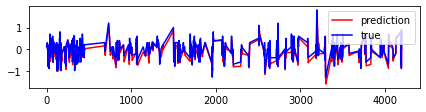

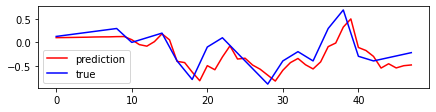

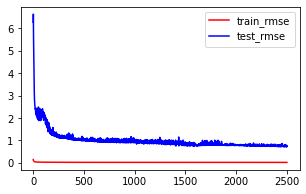

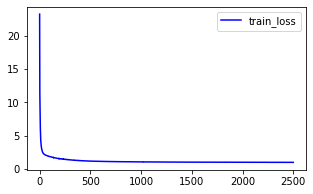

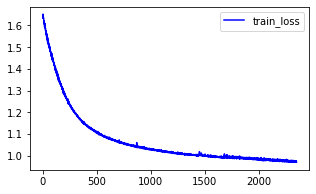

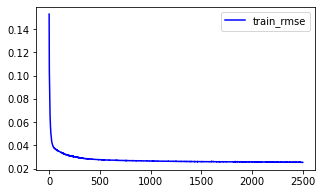

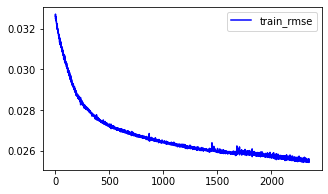

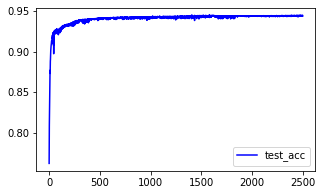

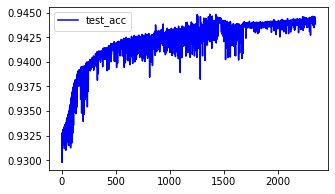

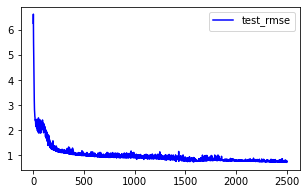

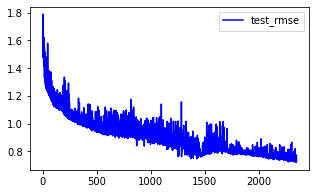

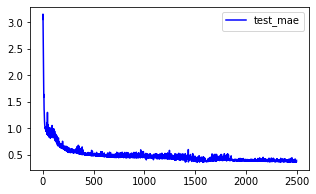

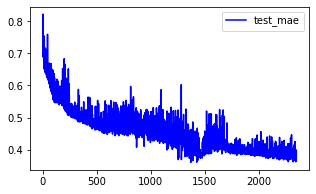

In [2]:
###### load data ######
if data_name == '3611817550':
    data, adj = load_assist_data('3611817550', model_name)
#if data_name == 'sh':
#    data, adj = load_sh_data('sh')

### Perturbation Analysis
def MaxMinNormalization(x,Max,Min):
    x = (x-Min)/(Max-Min)
    return x

if noise_name == 'Gauss':
    Gauss = np.random.normal(0,PG,size=data.shape)
    noise_Gauss = MaxMinNormalization(Gauss,np.max(Gauss),np.min(Gauss))
    data = data + noise_Gauss
elif noise_name == 'Possion':
    Possion = np.random.poisson(PG,size=data.shape)
    noise_Possion = MaxMinNormalization(Possion,np.max(Possion),np.min(Possion))
    data = data + noise_Possion
else:
    data = data

time_len = data.shape[0]
num_nodes = data.shape[1]
data1 =np.mat(data,dtype=np.float32)


############## normalization ###############
price_frame = data1
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
data1 = min_max_scaler.fit_transform(price_frame)
#max_value = np.max(data1)
max_value = 1
#data1  = data1/max_value

#data1.columns = data.columns
if model_name == 'ast-gcn':
    if scheme == 1:
        name = 'add direction dim'
    elif scheme == 2:
        name = 'add beach_width dim'
    elif scheme == 3:
        name = 'add Reservoir_water_level dim'
    elif scheme == 4:
        name = 'add phreatic_line dim'
    elif scheme == 5:
        name = 'add precipitation dim'
    elif scheme == 6:
        name = 'add dynamic attribute dim'
    else:
        name = 'add direction + dynamic attributes dim'

if model_name == 'tgcn':
    name = 'tgcn'
if model_name == 'gru':
    name = 'gru'

print('model:', model_name)
print('scheme:', name)
print('noise_name:', noise_name)
print('noise_param:', PG)

trainX, trainY, testX, testY = preprocess_data(data1, time_len, train_rate, seq_len, pre_len, model_name, scheme)

totalbatch = int(trainX.shape[0]/batch_size)
training_data_count = len(trainX)

def TGCN(_X, _weights, _biases):
    ###
    cell_1 = tgcnCell(gru_units, adj, num_nodes=num_nodes)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell_1], state_is_tuple=True)
    _X = tf.unstack(_X, axis=1)
    outputs, states = tf.nn.static_rnn(cell, _X, dtype=tf.float32)
    m = []
    for i in outputs:
        o = tf.reshape(i,shape=[-1,num_nodes,gru_units])
        o = tf.reshape(o,shape=[-1,gru_units])
        m.append(o)
    last_output = m[-1]
    output = tf.matmul(last_output, _weights['out']) + _biases['out']
    output = tf.reshape(output,shape=[-1,num_nodes,pre_len])
    output = tf.transpose(output, perm=[0,2,1])
    output = tf.reshape(output, shape=[-1,num_nodes])
    return output, m, states

def GRU(_X, weights, biases):
    ###
    cell_1 = GRUCell(gru_units,num_nodes=num_nodes)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell_1], state_is_tuple=True)
    _X = tf.unstack(_X, axis=1)
    outputs, states = tf.nn.static_rnn(cell, _X, dtype=tf.float32)
    m = []
    for i in outputs:
        o = tf.reshape(i,shape=[-1,num_nodes,gru_units])
        o = tf.reshape(o,shape=[-1,gru_units])
        m.append(o)
    last_output = m[-1]
    output = tf.matmul(last_output, weights['out']) + biases['out']
    output = tf.reshape(output,shape=[-1,num_nodes,pre_len])
    output = tf.transpose(output, perm=[0,2,1])
    output = tf.reshape(output, shape=[-1,num_nodes])

    return output, m, states

###### placeholders ######
if model_name == 'ast-gcn':
    if scheme == 1:
        inputs = tf.placeholder(tf.float32, shape=[None, seq_len+1, num_nodes])
    elif scheme == 2:
        inputs = tf.placeholder(tf.float32, shape=[None, seq_len*2+pre_len, num_nodes])
    elif scheme == 3:
        inputs = tf.placeholder(tf.float32, shape=[None, seq_len*2+pre_len, num_nodes])
    elif scheme == 4:
        inputs = tf.placeholder(tf.float32, shape=[None, seq_len*2+pre_len, num_nodes])
    elif scheme == 5:
        inputs = tf.placeholder(tf.float32, shape=[None, seq_len*2+pre_len, num_nodes])
    elif scheme == 6:
        inputs = tf.placeholder(tf.float32, shape=[None, seq_len+pre_len, num_nodes])
    else:
        inputs = tf.placeholder(tf.float32, shape=[None, seq_len*5+pre_len*4+1, num_nodes])#公式为 seq_len *（特征矩阵个数+动态因子个数）+ pre_len *（动态因子个数）+ 1

else:
    inputs = tf.placeholder(tf.float32, shape=[None, seq_len, num_nodes])

labels = tf.placeholder(tf.float32, shape=[None, pre_len, num_nodes])

# Graph weights
weights = {
    'out': tf.Variable(tf.random_normal([gru_units, pre_len], mean=1.0), name='weight_o')}
biases = {
    'out': tf.Variable(tf.random_normal([pre_len]),name='bias_o')}

if model_name == 'gru':
    pred,ttts,ttto = GRU(inputs, weights, biases)
if model_name == 'tgcn':
    pred,ttts,ttto = TGCN(inputs, weights, biases)

y_pred = pred

###### optimizer ######
lambda_loss = 0.0015
Lreg = lambda_loss * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
label = tf.reshape(labels, [-1,num_nodes])
##loss
print('y_pred_shape:', y_pred.shape)
print('label_shape:', label.shape)
loss = tf.reduce_mean(tf.nn.l2_loss(y_pred-label) + Lreg)
#loss = tf.reduce_mean(tf.square(label-y_pred))
##rmse
error = tf.sqrt(tf.reduce_mean(tf.square(y_pred-label)))
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

###### Initialize session ######
variables = tf.global_variables()
saver = tf.train.Saver(tf.global_variables())  
#sess = tf.Session()

#改动态获取GPU
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())
#out = 'out/%s'%(model_name)
out = 'out/%s_%s'%(model_name,noise_name)
path1 = 'MinMAXTGCNadj2%s_%s_%s_lr%r_batch%r_unit%r_seq%r_pre%r_epoch%r_scheme%r_PG%r'%(model_name,name,data_name,lr,batch_size,gru_units,seq_len,pre_len,training_epoch,scheme,PG)
path = os.path.join(out,path1)
if not os.path.exists(path):
    os.makedirs(path)

###### evaluation ######
def evaluation1(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    return rmse, mae
def evaluation2(a,b):
    F_norm = la.norm(a-b,'fro')/la.norm(a,'fro')
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    return 1-F_norm, r2, var

x_axe,batch_loss,batch_rmse,batch_pred = [], [], [], []
test_loss,test_rmse,test_mae,test_acc,test_r2,test_var,test_pred = [],[],[],[],[],[],[]
test_renor_pred = []

for epoch in range(training_epoch):
    for m in range(totalbatch):
        mini_batch = trainX[m * batch_size : (m+1) * batch_size]
        mini_label = trainY[m * batch_size : (m+1) * batch_size]
        _, loss1, rmse1, train_output = sess.run([optimizer, loss, error, y_pred],
                                                 feed_dict = {inputs:mini_batch, labels:mini_label})
        batch_loss.append(loss1)
        batch_rmse.append(rmse1 * max_value)

     # Test completely at every epoch
    loss2, rmse2, test_output = sess.run([loss, error, y_pred],
                                         feed_dict = {inputs:testX, labels:testY})

    testoutput = np.abs(test_output)
    test_label = np.reshape(testY,[-1,num_nodes])
    
# ############## normalization ###############
#     price_frame = pd.DataFrame(pd.read_excel(r'./data_35-5_under10float/3611817550_feature_matrix_X.xlsx', header=0))
#     min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
#     x_minmax = min_max_scaler.fit_transform(price_frame)
    
    acc, r2_score, var_score = evaluation2(test_label, testoutput)
    
############## renormalization ###############  
#     test_label1 = test_label * max_value
#     test_output1 = testoutput * max_value
    test_label1 = min_max_scaler.inverse_transform(test_label)
    test_output1 = min_max_scaler.inverse_transform(testoutput)
    
    rmse, mae = evaluation1(test_label1, test_output1)
    test_loss.append(loss2)
#     test_rmse.append(rmse * max_value)
#     test_mae.append(mae * max_value)
    test_rmse.append(rmse)
    test_mae.append(mae)
    test_acc.append(acc)
    test_r2.append(r2_score)
    test_var.append(var_score)
    test_pred.append(test_output1)
    test_renor_pred.append(testoutput)
    
    print('Iter:{}'.format(epoch),
          'train_rmse:{:.4}'.format(batch_rmse[-1]),
          'test_loss:{:.4}'.format(loss2),
          'test_rmse:{:.4}'.format(rmse),
          'test_acc:{:.4}'.format(acc))
    
    if (epoch % 500 == 0):        
        saver.save(sess, path+'/model_100/ASTGCN_pre_%r'%epoch, global_step = epoch)
        
time_end = time.time()
print(time_end-time_start,'s')

############## visualization ###############
#x = [i for i in range(training_epoch)]
b = int(len(batch_rmse)/totalbatch)
batch_rmse1 = [i for i in batch_rmse]
train_rmse = [(sum(batch_rmse1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]
batch_loss1 = [i for i in batch_loss]
train_loss = [(sum(batch_loss1[i*totalbatch:(i+1)*totalbatch])/totalbatch) for i in range(b)]
#test_rmse = [float(i) for i in test_rmse]

index = test_rmse.index(np.min(test_rmse))
test_result = test_pred[index]
test_renor_pred = test_renor_pred[index]
var = pd.DataFrame(test_result)
var2 = pd.DataFrame(test_label1)
var.to_csv(path+'/test_prediction.csv',index = False,header = False)
var2.to_csv(path+'/test_true.csv',index = False,header = False)
plot_result(test_result,test_label1,path)
plot_error(train_rmse,train_loss,test_rmse,test_acc,test_mae,path)
evalution = []
evalution.append(np.min(test_rmse))
evalution.append(test_mae[index])
evalution.append(test_acc[index])
evalution.append(test_r2[index])
evalution.append(test_var[index])
evalution = pd.DataFrame(evalution)
evalution.to_csv(path+'/evalution_all.csv',index=False,header=None)

print('model_name:', model_name)
print('scheme:', scheme)
print('name:', name)
print('noise_name:', noise_name)
print('PG:', PG)
print('min_rmse:%r'%(np.min(test_rmse)),
      'min_mae:%r'%(test_mae[index]),
      'max_acc:%r'%(test_acc[index]),
      'r2:%r'%(test_r2[index]),
      'var:%r'%test_var[index])

test_rmse.clear()
test_mae.clear()
test_acc.clear()
test_r2.clear()
test_var.clear()
j=1
for i in range(num_nodes):
    a = test_label1[:,i]
    b = test_result[:,i]
    a = np.array(a)
    a = np.reshape(a,[-1, pre_len])
    b = np.array(np.transpose(np.mat(b)))
    b = b.repeat(pre_len ,axis=1)
    rmse, mae = evaluation1(a, b)
    
    a = test_label[:,i]
    b = test_renor_pred[:,i]
    a = np.array(a)
    a = np.reshape(a,[-1, pre_len])
    b = np.array(np.transpose(np.mat(b)))
    b = b.repeat(pre_len ,axis=1)
    acc,r2,var = evaluation2(a, b)
    if r2<0:
        r2=0
    print('第%r列 TGCN_rmse:%r\n'%(j,rmse),
          '第%r列 TGCN_mae:%r\n'%(j,mae),
          '第%r列 TGCN_acc:%r\n'%(j,acc),
          '第%r列 TGCN_r2:%r\n'%(j,r2),
          '第%r列 TGCN_var:%r\n'%(j,var))
    print('\n')
    test_rmse.append(rmse)
    test_mae.append(mae)
    test_acc.append(acc)
    test_r2.append(r2)
    test_var.append(var)
    j += 1
rmse = np.array(test_rmse)
mae = np.array(test_mae)
acc = np.array(test_acc)
r2 = np.array(test_r2)
var = np.array(test_var)
rmse = np.mean(rmse)
mae = np.mean(mae)
acc = np.mean(acc)
r2 = np.mean(r2)
var = np.mean(var)
print('mean_rmse:%r'%(rmse),
      'mean_mae:%r'%(mae),
      'meam_acc:%r'%(acc),
      'mean_r2:%r'%(r2),
      'mean_var:%r'%var)
evalution2 = []
evalution2.append(rmse)
evalution2.append(mae)
evalution2.append(acc)
evalution2.append(r2)
evalution2.append(var)
evalution2 = pd.DataFrame(evalution2)
evalution2.to_csv(path+'/evalution_mean.csv',index=False,header=None)


#记得回溯minmax归一化结构